### Graph network [example]

In [1]:
import os
import pandas as pd
import numpy as np
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

### Custom Graphs

In [3]:
ind_data = pd.read_csv("../data/raw_data/rawdat/IND/quadruple_idx.txt",sep='\t', nrows = 10000, names=['src','rel','dst','time'])
# ind_data.drop("Unnamed: 0", axis=1, inplace=True)
ind_data.reset_index(drop=True)
ind_data.head()

,src,rel,dst,time
0,2,121,85,0
1,31,58,1,0
2,1,58,31,0
3,0,49,2,0
4,2,15,9,0


In [4]:
ind_data.dropna(inplace=True)

In [4]:
def rule_1(data, src, relation, target, date): # apply static symmetry
    grouped = data.groupby(by = [relation, date])[[src, target]].apply(lambda x:x).droplevel(2)
    grouped = grouped.reset_index()
    grouped.drop_duplicates(subset=['time','src','dst'], inplace=True)
    merged = pd.merge(grouped, grouped, left_on=['src', 'dst', "rel", "time"], right_on=['dst', 'src',"rel", "time"])
    merged.drop(merged.filter(regex='_y$').columns, axis=1, inplace=True)
    merged.rename(columns = {"src_x":"src","dst_x":"dst"}, inplace=True)
    return merged

In [5]:
rule_1_grouped = rule_1(ind_data,'src','rel','dst','time')

In [6]:
rule_1_grouped.head(10)

,rel,time,src,dst
0,0,13,59,717
1,0,13,717,59
2,0,40,0,68
3,0,40,68,0
4,0,54,31,1
5,0,54,1,31
6,0,61,10,3
7,0,61,3,10
8,2,0,59,0
9,2,0,0,59


In [7]:
def rule_2(data, src, relation, target, date,text=None): # apply static symmetry
    if text:
        grouped = data.groupby(by = [date])[[src, target, relation, text]].apply(lambda x:x).droplevel(1)
    else:
        grouped = data.groupby(by = [date])[[src, target, relation]].apply(lambda x:x).droplevel(1)
    grouped = grouped.reset_index()
    # grouped.drop_duplicates(subset=['relation','source','target'], inplace=True)
    merged = pd.merge(grouped, grouped, left_on=[src, target, date], right_on=[target, src, date])
    # merged.drop(merged.filter(regex='_y$').columns, axis=1, inplace=True)
    # merged.rename(columns = {"source_x":"source","target_x":"target"}, inplace=True)
    return merged

In [8]:
rule_2_grouped = rule_2(ind_data,'src','rel','dst','time')

In [9]:
rule_2_grouped.head(10)

,time,src_x,dst_x,rel_x,src_y,dst_y,rel_y
0,0,31,1,58,1,31,58
1,0,31,1,58,1,31,58
2,0,31,1,58,1,31,58
3,0,31,1,58,1,31,58
4,0,31,1,58,1,31,0
5,0,31,1,58,1,31,0
6,0,31,1,58,1,31,43
7,0,31,1,58,1,31,29
8,0,31,1,58,1,31,0
9,0,31,1,58,1,31,58


In [10]:
inverse_rule_mappings = defaultdict(dict)

In [11]:
for i in range(len(rule_2_grouped)):
    if rule_2_grouped.rel_x[i] != rule_2_grouped.rel_y[i]:
        inverse_rule_mappings[rule_2_grouped.rel_x[i]][rule_2_grouped.rel_y[i]] = inverse_rule_mappings[rule_2_grouped.rel_x[i]].get(rule_2_grouped.rel_y[i],0) + 1

In [34]:
most_related_events = defaultdict(list)

In [39]:
for relation, mappings in inverse_rule_mappings.items():
    mappings = sorted(mappings.items(), key= lambda x: x[1], reverse=True)
    for events in mappings[:3]:
        most_related_events[relation].append(events[0])

In [5]:
ind_data_ten_days = ind_data[ind_data.time<=10]

In [6]:
ind_data_ten_days.head(10)

,src,rel,dst,time
0,2,121,85,0
1,31,58,1,0
2,1,58,31,0
3,0,49,2,0
4,2,15,9,0
5,2,7,92,0
6,111,64,2,0
7,111,0,20,0
8,111,15,53,0
9,70,5,9,0


In [7]:
def get_indices_with(data):
    idx = [i for i in range(len(data))]
    return np.array(idx)

In [8]:
def comp_deg_norm(g):
    in_deg = g.in_degrees(range(g.number_of_nodes())).float()
    in_deg[torch.nonzero(in_deg == 0, as_tuple=False).view(-1)] = 1
    norm = 1.0 / in_deg
    return norm

In [9]:
edge_indices = get_indices_with(ind_data_ten_days)

In [10]:
src = np.asarray(ind_data_ten_days['src'].values)
dst = np.asarray(ind_data_ten_days['dst'].values)
rel = np.asarray(ind_data_ten_days['rel'].values)
date = np.asarray(ind_data_ten_days['time'].values)

In [11]:
uniq_v, edges = np.unique((src, dst), return_inverse=True)  
# src, dst = np.reshape(edges, (2, -1))
g = dgl.DGLGraph()
g.add_nodes(len(uniq_v))
g.add_edges(src, dst, {'eid': torch.from_numpy(edge_indices)}) # array list
# norm = comp_deg_norm(g)
# g.ndata.update({'id': torch.from_numpy(uniq_v).long().view(-1, 1)})
# g.ndata.update({'id': torch.from_numpy(uniq_v).long().view(-1, 1), 'norm': norm.view(-1, 1)})
g.edata['type'] = torch.LongTensor(rel)
g.edata['date'] = torch.LongTensor(date)
g.ids = {}
idx = 0
for id in uniq_v:
    g.ids[id] = idx
    idx += 1

C:\Users\desai\anaconda3\envs\cuda_test\lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [12]:
g.edges(form='all')

(tensor([   2,   31,    1,  ...,  576,  132, 3055]),
 tensor([85,  1, 31,  ..., 10, 10,  2]),
 tensor([   0,    1,    2,  ..., 1465, 1466, 1467]))

In [54]:
g.edata['date'].unique(return_counts=True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 tensor([123, 108,  95, 125, 110, 158, 153, 163, 138, 133, 162]))

In [56]:
sg1 = dgl.node_subgraph(g, [1,31], store_ids=True)

In [57]:
sg1.edata

{'eid': tensor([   2,   15,   18,   20,   26,   27,   96,   97,  107,  144,  147,  221,
         222,  422,  457,  720,  895,  900,  996, 1044, 1089, 1145, 1351,    1,
          19,  103,  104,  150,  162,  230,  750, 1078], dtype=torch.int32), 'type': tensor([58, 58, 58, 58,  0,  0, 43, 29,  0, 58,  0, 58, 29, 18, 43,  2,  3,  3,
        12, 12, 12, 12,  0, 58, 58, 41, 13, 41, 13, 58,  2, 11]), 'date': tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  3,  4,  6,  7,  7,
         7,  8,  8,  8, 10,  0,  0,  0,  0,  1,  1,  1,  6,  8]), '_ID': tensor([   2,   15,   18,   20,   26,   27,   96,   97,  107,  144,  147,  221,
         222,  422,  457,  720,  895,  900,  996, 1044, 1089, 1145, 1351,    1,
          19,  103,  104,  150,  162,  230,  750, 1078])}

In [25]:
sg1.edata[dgl.EID]

tensor([   2,   15,   18,   20,   26,   27,   96,   97,  107,  144,  147,  221,
         222,  422,  457,  720,  895,  900,  996, 1044, 1089, 1145, 1351,    1,
          19,  103,  104,  150,  162,  230,  750, 1078])

In [59]:
left, right, rel = 1, 31, 58

In [60]:
for i in range(len(g.edges(form='all')[0])):
    if int(g.edges(form='all')[0][i]) == left and int(g.edges(form='all')[1][i]) == right and int(g.edata['type'][i]) == rel:
        print(int(g.edges(form='all')[0][i]), int(g.edges(form='all')[1][i]), int(g.edges(form='all')[2][i]), int(g.edata['type'][i]), int(g.edata['date'][i]))

1 31 2 58 0
1 31 15 58 0
1 31 18 58 0
1 31 20 58 0
1 31 144 58 1
1 31 221 58 1


In [47]:
for i in range(len(g.edges(form='all')[0])):
    if int(g.edges(form='all')[0][i]) == right and int(g.edges(form='all')[1][i]) != left and (int(g.edata['type'][i]) in most_related_events[right]):
        print(int(g.edges(form='all')[0][i]), int(g.edges(form='all')[1][i]), int(g.edata['type'][i]))

In [49]:
for i in range(len(g.edges(form='all')[0])):
    if int(g.edges(form='all')[1][i]) == left and int(g.edges(form='all')[0][i]) != right and (int(g.edata['type'][i]) in most_related_events[left]):
        print(int(g.edges(form='all')[0][i]), int(g.edges(form='all')[1][i]), int(g.edata['type'][i]))

0 1 3
122 1 3
27 1 10
27 1 10
276 1 3
276 1 3
242 1 4
2 1 3
364 1 4
364 1 4


In [13]:
folder_path = "D:\\personal-Shreyas\AIRS\\data\\raw_data\\rawdat\\IND"

In [25]:
def get_top_corr_events(folder_path):
    quadruple_idx_path = folder_path + '/quadruple_idx.txt'
    data = pd.read_csv(quadruple_idx_path, sep = '\t', names = ["src","rel","tgt","date"])
    data = data.groupby(by = ["date"])[["src", "tgt", "rel"]].apply(lambda x:x).droplevel(1)
    data = data.reset_index()
    merged = pd.merge(data, data, left_on=["src", "tgt", "date"], right_on=["tgt", "src", "date"])

    inverse_rule_mappings = defaultdict(dict)
    most_related_events = defaultdict(list)
    
    for i in range(len(merged)):
        if merged.rel_x[i] != merged.rel_y[i]:
            inverse_rule_mappings[merged.rel_x[i]][merged.rel_y[i]] = inverse_rule_mappings[merged.rel_x[i]].get(merged.rel_y[i],0) + 1
    for relation, mappings in inverse_rule_mappings.items():
        mappings = sorted(mappings.items(), key= lambda x: x[1], reverse=True)
        for events in mappings[:3]:
            most_related_events[relation].append(events[0])
    return most_related_events

In [38]:
def get_sg_by_entity_corr(graph, left, relation, right, date, most_related_events):
    edges = graph.edges(form='all')
    edata = graph.edata

    src_nodes = list(map(int, edges[0]))
    dst_nodes = list(map(int, edges[1]))
    rel_types = list(map(int, edata['type']))
    dates = list(map(int, edata['date']))

    main_events = []
    left_events = []
    right_events = []
    final_events_src = []
    final_events_dst = []
    relations = []
    time = []
    
    for i in range(len(src_nodes)):
        if src_nodes[i] == left and dst_nodes[i] == right and rel_types[i] == relation and dates[i] == date:
            main_events.append((src_nodes[i], rel_types[i], dst_nodes[i], dates[i]))

    for i in range(len(src_nodes)):
        if src_nodes[i]!= right and dst_nodes[i] == left and rel_types[i] in most_related_events[relation] and (dates[i]>=date-5 and dates[i]<=date+5):
            left_events.append((src_nodes[i], rel_types[i], dst_nodes[i], dates[i]))

    for i in range(len(src_nodes)):
        if src_nodes[i]== right and dst_nodes[i] != left and rel_types[i] in most_related_events[relation] and (dates[i]>=date-5 and dates[i]<=date+5):
            right_events.append((src_nodes[i], rel_types[i], dst_nodes[i], dates[i]))

    for i in set(main_events):
        final_events_src.append(i[0])
        final_events_dst.append(i[1])
        relations.append(i[2])
        time.append(i[3])

    for i in set(left_events):
        final_events_src.append(i[0])
        final_events_dst.append(i[1])
        relations.append(i[2])
        time.append(i[3])

    for i in set(right_events):
        final_events_src.append(i[0])
        final_events_dst.append(i[1])
        relations.append(i[2])
        time.append(i[3])
        
    final_events_src = torch.LongTensor(final_events_src)
    final_events_dst = torch.LongTensor(final_events_dst)
    
    # print(final_events_src, final_events_dst, relations, time)
    unique_nodes, edges = torch.unique(torch.cat((final_events_src, final_events_dst)), return_inverse=True)
    # print(len(unique_nodes))
    final_src, final_dst = torch.reshape(edges,(2,-1))
    
    sg = dgl.DGLGraph(num_nodes = len(unique_nodes))
    sg.add_edges(final_src, final_dst)
    sg.ndata.update({'id': unique_nodes.view(-1, 1)})
    sg.edata["type"] = torch.LongTensor(relations)
    sg.edata["date"] = torch.LongTensor(time)

    return set(main_events), set(left_events), set(right_events), sg

In [14]:
def construct_graph(folder_path):
    src, rel, dst, date = [], [], [], []
    quadruple_idx_path = folder_path + '/quadruple_idx.txt'
    with open (quadruple_idx_path, 'r') as qdrple:
        for line in qdrple:
            row = line.split()
            src.append(row[0])
            rel.append(row[1])
            dst.append(row[2])
            date.append(row[3])
    src = np.asarray(src, dtype="int64")
    dst = np.asarray(dst, dtype="int64")
    rel = np.asarray(rel, dtype="int64")
    date = np.asarray(date, dtype="int64")
    uniq_v = np.unique((src, dst))  
    g = dgl.graph((src,dst))
    # g.add_nodes(len(uniq_v))

    # g.add_edges(src, dst) # array list
    g.edata['type'] = torch.LongTensor(rel)
    g.edata['date'] = torch.LongTensor(date)
    g.ids = {}
    idx = 0
    for id in uniq_v:
        g.ids[id] = idx
        idx += 1
    
    return g

In [15]:
def plot_graph(graph):
    options = {
        'node_color': 'black',
        'node_size': 50,
        'width': 1,
    }
    G = dgl.to_networkx(graph)
    plt.figure(figsize=[15,7])
    nx.draw(G, **options)

In [16]:
print("Generating graph...")
graph = construct_graph(folder_path)
print("Graph Created!")

Generating graph...
Graph Created!


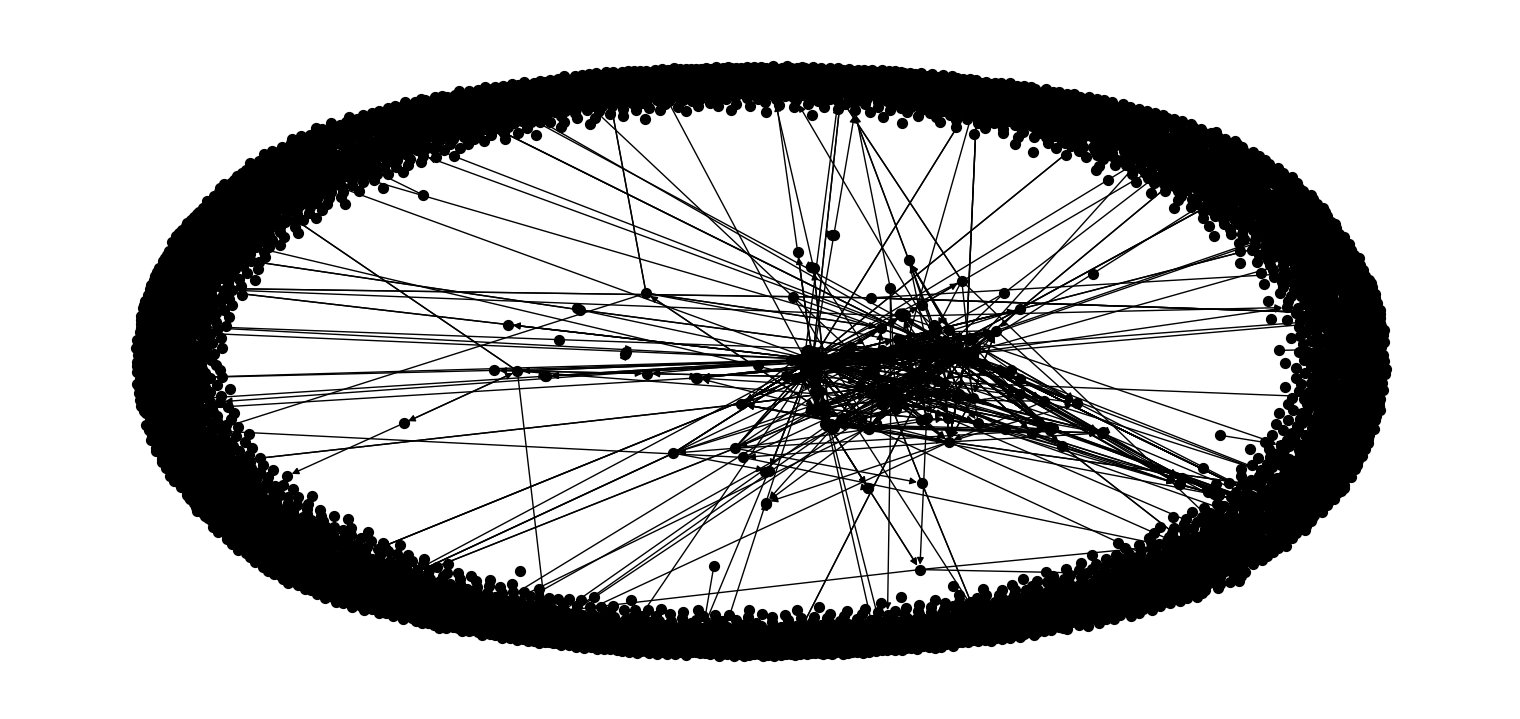

In [17]:
plot_graph(graph)

In [30]:
print("getting most correlted events...")
m_r_e = get_top_corr_events(folder_path)

getting most correlted events...


In [51]:
m_r_e

defaultdict(list,
            {58: [2, 3, 17],
             41: [1, 4, 5],
             13: [1, 3, 4],
             0: [8, 2, 3],
             43: [4, 7, 3],
             29: [19, 8, 18],
             7: [8, 1, 2],
             9: [8, 2, 17],
             8: [9, 7, 0],
             10: [1, 11, 14],
             11: [10, 4, 25],
             1: [4, 10, 3],
             3: [1, 8, 4],
             20: [1, 4, 3],
             4: [1, 14, 3],
             78: [1, 4, 19],
             50: [1, 3, 4],
             22: [4, 10, 3],
             14: [4, 10, 3],
             16: [1, 10, 4],
             46: [1, 4, 3],
             30: [1, 4, 10],
             39: [2, 12, 0],
             28: [4, 10, 3],
             2: [17, 9, 0],
             49: [4, 3, 10],
             23: [1, 10, 4],
             5: [1, 3, 4],
             33: [1, 4, 3],
             32: [8, 1, 9],
             21: [19, 8, 1],
             36: [3, 7, 10],
             54: [4, 10, 3],
             26: [1, 3, 4],
             6: 

#### Example 1

In [39]:
print("getting left and right events")
main_events, left_events, right_events, sg = get_sg_by_entity_corr(graph, 1, 58, 31, 0, m_r_e)

getting left and right events


In [40]:
main_events

{(1, 58, 31, 0)}

In [41]:
left_events

{(0, 3, 1, 0), (122, 3, 1, 2), (236, 2, 1, 4), (276, 3, 1, 5)}

In [42]:
right_events

set()

In [43]:
sg.edata["type"]

tensor([31,  1,  1,  1,  1])

In [44]:
sg.ndata["id"]

tensor([[  0],
        [  1],
        [  2],
        [  3],
        [ 58],
        [122],
        [236],
        [276]])

#### Example 2

In [45]:
print("getting left and right events")
main_events, left_events, right_events, sg = get_sg_by_entity_corr(graph, 0,49,2,5, m_r_e)

getting left and right events


In [46]:
main_events

set()

In [47]:
left_events

{(1, 3, 0, 0),
 (5, 3, 0, 7),
 (6, 3, 0, 6),
 (6, 3, 0, 7),
 (9, 3, 0, 9),
 (10, 3, 0, 4),
 (10, 3, 0, 5),
 (27, 10, 0, 3),
 (27, 10, 0, 4),
 (27, 10, 0, 5),
 (27, 10, 0, 6),
 (30, 3, 0, 8),
 (30, 3, 0, 9),
 (36, 10, 0, 5),
 (36, 10, 0, 6),
 (53, 10, 0, 0),
 (72, 3, 0, 8),
 (91, 3, 0, 9),
 (122, 3, 0, 2),
 (172, 4, 0, 9),
 (291, 10, 0, 5),
 (1199, 10, 0, 5),
 (1364, 10, 0, 5)}

In [48]:
right_events

{(2, 3, 10, 0), (2, 3, 29, 0)}

In [49]:
sg.edata["type"]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 10, 29])

In [50]:
sg.ndata["id"]

tensor([[   1],
        [   2],
        [   3],
        [   4],
        [   5],
        [   6],
        [   9],
        [  10],
        [  27],
        [  30],
        [  36],
        [  53],
        [  72],
        [  91],
        [ 122],
        [ 172],
        [ 291],
        [1199],
        [1364]])